In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers # type: ignore
import matplotlib.pyplot as plt

In [7]:
#1->Each batch contains 32 images
#2->image(heigth,width)=(256x256)
#3->inage_info(height,width,r,g,b)
#4->number of times each batch is iterated

In [8]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=30

In [9]:
# here all the 3 datasets are combined into one and the images are resized to 256x256
# the dataset is shuffled and the batch size is set to 32

# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "PlantVillage",
#     shuffle=True,
#     image_size=(IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../leaves_data',
    seed=124,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE 
    )

Found 7024 files belonging to 2 classes.


In [10]:
# displays labes as class names of the images
class_names = dataset.class_names
class_names

['non_potato_leaves', 'potato_leaves']

In [11]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(32, 256, 256, 3)
[1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1]


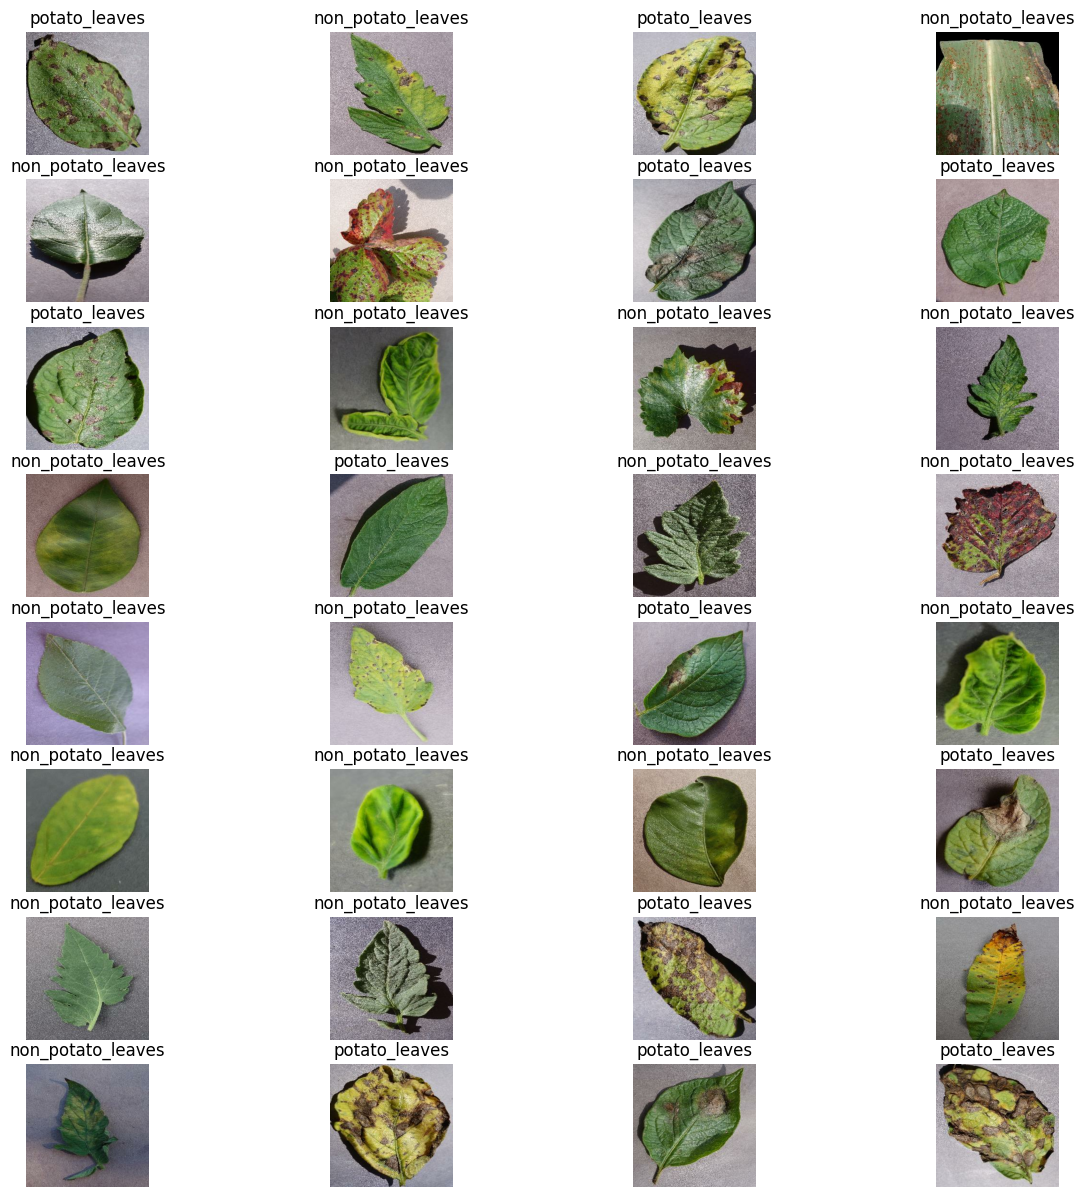

In [12]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(32):
        ax=plt.subplot(8,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[labels_batch[i]])

In [13]:
train_size=0.8
len(dataset)*train_size

176.0

In [14]:
train_ds=dataset.take(int(len(dataset)*train_size))
len(train_ds)

176

In [15]:
test_ds=dataset.skip(int(len(train_ds)))
len(test_ds)

44

In [16]:
vali_size=0.1
len(dataset)*vali_size

22.0

In [17]:
vali_ds=test_ds.take(int(len(dataset)*vali_size))
len(vali_ds)

22

In [18]:
test_ds=test_ds.skip(int(len(vali_ds)))
len(test_ds)

22

In [19]:
def get_partioned_dataset(ds, train_split=0.8, vali_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    assert (train_split + vali_split + test_split) == 1

    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size=int(ds_size* train_split)
    vali_size=int(ds_size* vali_split)
    test_size=int(ds_size* test_split)

    return train_ds, vali_ds, test_ds

In [20]:
train_ds, vali_ds, test_ds = get_partioned_dataset(dataset)
print(len(train_ds))
print(len(vali_ds))
print(len(test_ds))

176
22
22


In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
vali_ds = vali_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  #resize the images to (256X256)
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  #rescale the pixel values to [0,1] dividing by 255
  layers.Rescaling(1.0/255),
])

In [23]:
#here we are using data augmentation to increase the size of the training dataset
# this helps to prevent overfitting and improve the model's performance

from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras import layers # type: ignore

data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal and_vertical"),
    layers.RandomRotation(0.2)
]) 

In [24]:
input_image = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,kernel_size=(3,3), activation='relu', input_shape=input_image),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    
    layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='sigmoid')
])

model.build(input_shape=input_image)

d:\USER\OneDrive\Desktop\Final_yr\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,826 (1.06 MB)

 Trainable params: 277,826 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history =model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=vali_ds,
    verbose=1,
    # epochs=EPOCHS,
    epochs = 30
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 178s 907ms/step - accuracy: 0.7457 - loss: 0.5173 - val_accuracy: 0.8139 - val_loss: 0.4019
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 161s 912ms/step - accuracy: 0.8525 - loss: 0.3293 - val_accuracy: 0.8239 - val_loss: 0.3698
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 151s 859ms/step - accuracy: 0.8750 - loss: 0.2942 - val_accuracy: 0.8565 - val_loss: 0.2997
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 152s 865ms/step - accuracy: 0.8951 - loss: 0.2481 - val_accuracy: 0.8807 - val_loss: 0.2927
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 149s 846ms/step - accuracy: 0.9070 - loss: 0.2263 - val_accuracy: 0.8722 - val_loss: 0.3203
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 145s 823ms/step - accuracy: 0.9226 - loss: 0.1884 - val_accuracy: 0.9091 - val_loss: 0.2312
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 147s 834ms/step - accuracy: 0.9276 - loss: 0.1859 - val_accuracy: 0.9062 - val_loss: 0.2608
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 143s 813ms/step - accuracy: 0.9327 -

In [28]:
score = model.evaluate(test_ds)
score

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9811 - loss: 0.0552


[0.05516644939780235, 0.9811046719551086]

In [29]:
history.history['accuracy']

[0.7457386255264282,
 0.8524503111839294,
 0.875,
 0.8950639367103577,
 0.9069602489471436,
 0.9225852489471436,
 0.9275568127632141,
 0.9327059388160706,
 0.9405184388160706,
 0.9396306872367859,
 0.9495738744735718,
 0.9557883739471436,
 0.9664417505264282,
 0.9664417505264282,
 0.9545454382896423,
 0.9644886255264282,
 0.9735440611839294,
 0.9703480005264282,
 0.9712358117103577,
 0.9673295617103577,
 0.9781605005264282,
 0.9772727489471436,
 0.9801136255264282,
 0.9763849377632141,
 0.978515625,
 0.9817116260528564,
 0.9778053760528564,
 0.9818891882896423,
 0.9769176244735718,
 0.9865056872367859]

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy'] 
loss=history.history['loss']
val_loss=history.history['val_loss']

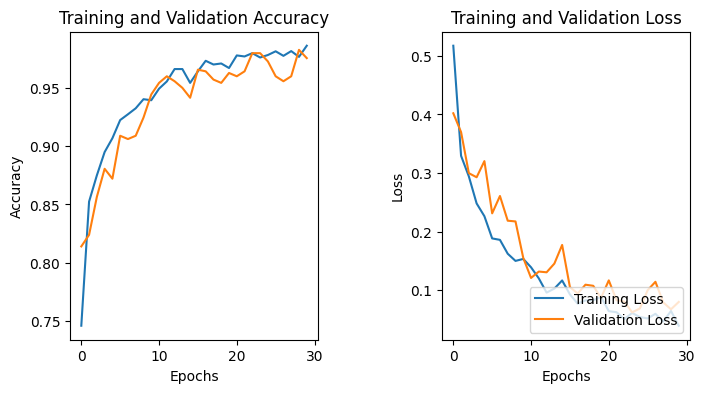

In [31]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')   
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='lower right')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [32]:
model_version = 2

In [33]:
model.export(f"../models/D_{model_version}")


INFO:tensorflow:Assets written to: ../models/D_2\assets


INFO:tensorflow:Assets written to: ../models/D_2\assets


Saved artifact at '../models/D_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2900793079184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900793079760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900793081296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900793081680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907623056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907622480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907624784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907624016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907625168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900907624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2900793080528: TensorSpec(shape=(), d

In [34]:
model.save(f"../models/detect_V{model_version}.keras")


In [35]:
model.save(f"../models/leaf_detect_v{model_version}.h5")